In [1]:
#from scipy import stats, special, math
import numpy as np
import matplotlib.pyplot as plt
#import matplotlib.gridspec as gridspec
%matplotlib inline
import pymc3 as pm
import arviz as az
import pandas as pd
from theano import shared
import warnings
import theano
import theano.tensor as tt
#import time
import pickle

az.style.use('arviz-darkgrid')
warnings.filterwarnings('ignore')

# Gather the data

In [2]:
prison = pd.read_csv('/home/mach1ne/prisonLF.csv', sep=",")
prison = prison.drop('Unnamed: 0', axis =1)
prison['t'] = prison['t'].astype('datetime64[ns]')

In [43]:
prison_pivot = prison.pivot(index='t',columns=['state', 'gender', 'legal'], values='count')

n_all = 48
# We will be forecasting the last 8 points -> 2015 and 2016
y = prison_pivot.iloc[:-8, :]
y_h = prison_pivot.iloc[n_all-8:n_all, :]
y_h = y_h.values
y_all = prison_pivot.values 

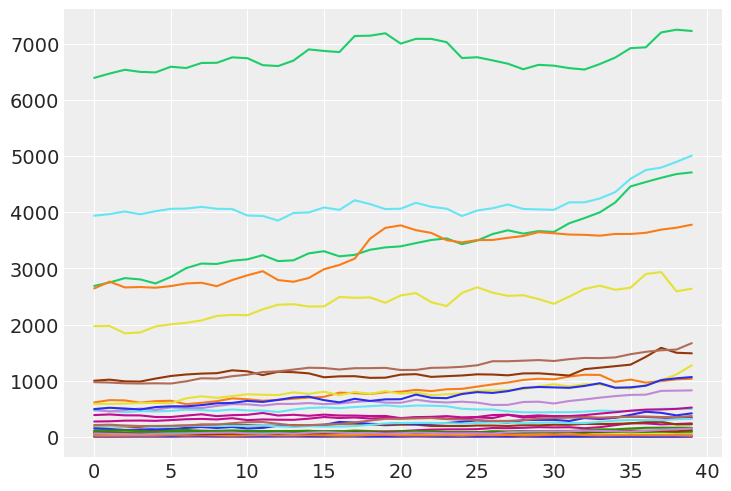

In [4]:
n=y.shape[0]
s = y.shape[1]
state_idx = pd.get_dummies(
        [i[0] for i in y]
    ).values.argmax(1)
state_idx = np.tile(state_idx, (n,1)).flatten('F')
gender_idx = pd.get_dummies(
        [i[1] for i in y]
    ).values.argmax(1)
gender_idx = np.tile(gender_idx, (n,1)).flatten('F')

legal_idx = pd.get_dummies(
        [i[2] for i in y]
    ).values.argmax(1)
legal_idx = np.tile(legal_idx, (n,1)).flatten('F')

state = np.unique(state_idx).shape[0]
gender = np.unique(gender_idx).shape[0]
legal = np.unique(legal_idx).shape[0]

n_series_idx = np.tile(np.arange(s), (n,1)).flatten('F')
n_series_idx_list = np.arange(s)

state_idx_list = pd.get_dummies(
        [i[0] for i in y]
    ).values.argmax(1)

gender_idx_list = pd.get_dummies(
        [i[1] for i in y]
    ).values.argmax(1)

legal_idx_list = pd.get_dummies(
        [i[2] for i in y]
    ).values.argmax(1)

state = np.unique(state_idx_list).shape[0]
gender = np.unique(gender_idx_list).shape[0]
legal = np.unique(legal_idx_list).shape[0]

states_ = []
gender_ = []
legal_ = []
[states_.append(i[0]) for i in y.columns]
[gender_.append(i[1]) for i in y.columns]
[legal_.append(i[2]) for i in y.columns]

states_ = np.unique(states_)
gender_ = np.unique(gender_)
legal_ = np.unique(legal_)

n_series = y.columns.unique().shape[0]
y = y.values
s = y.shape[1]


y_ = y

# Forecast 
X = np.concatenate((np.repeat(np.arange(y.shape[0]).reshape(-1,1), s, axis=1).flatten('F').reshape(-1,1), np.repeat(np.arange(y.shape[1]),n).reshape(-1,1)), axis=1)

x = np.arange(y.shape[0]).reshape(y.shape[0], 1)

plt.plot(x, y);

y_ = y_.T.ravel()

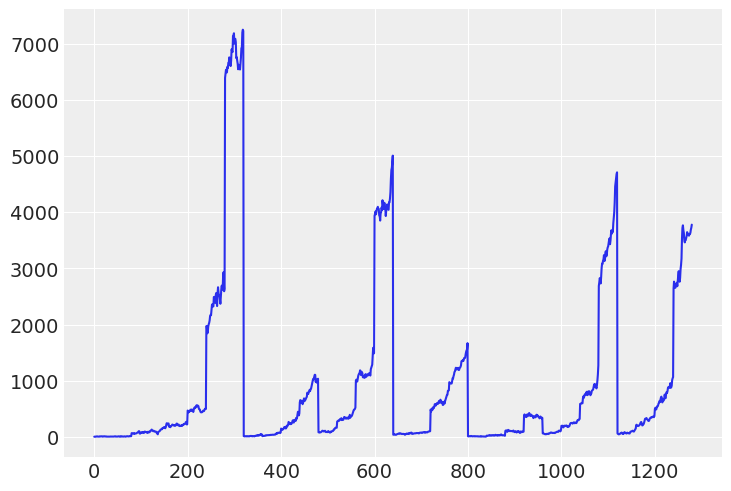

In [5]:
plt.plot(y_);

# Defining the model

### Defining a custom mean function for the GPs

In [6]:
# Only allows to forecast one series at a time for now

class LinearMean(pm.gp.mean.Mean):

    def __init__(self, 
                 intercepts, 
                 g1, 
                 g2, 
                 g3, 
                 slopes):
        self.b = slopes
        self.a0 = intercepts
        self.a1 = g1
        self.a2 = g2
        self.a3 = g3

    def __call__(self, X):
        size_r = X.shape[0]
        series = int(X[0,1]) # series that we are forecasting

        X = theano.shared(X)

        if size_r == n*s:
            # fitting
            return tt.flatten(((X[:,0].reshape((s,-1)).T * self.b.reshape((1,-1))) 
                           + self.a0.reshape((1,-1))[:,n_series_idx_list] 
                           + self.a1.reshape((1,-1))[:,state_idx_list] 
                           + self.a2.reshape((1,-1))[:,gender_idx_list] 
                           + self.a3.reshape((1,-1))[:,legal_idx_list]
                          ).T)
        else:
            # forecasting
            return tt.squeeze(X[:,0] * tt.repeat(self.b.reshape((1,-1))[:,n_series_idx_list[series]], size_r) 
                           + tt.repeat(self.a0.reshape((1,-1))[:,n_series_idx_list[series]], size_r)
                           + tt.repeat(self.a1.reshape((1,-1))[:,state_idx_list[series]],size_r)
                           + tt.repeat(self.a2.reshape((1,-1))[:,gender_idx_list[series]],size_r) 
                           + tt.repeat(self.a3.reshape((1,-1))[:,legal_idx_list[series]],size_r)
                          )

### Prior predictive checks

In [22]:
with pm.Model() as model_h_cox_gp_cor:
    
    # Hyper-parameter priors
    l_t = pm.Gamma('l_t', alpha=2, beta=1)
    l_p = pm.Gamma('l_p', alpha=2, beta=1)
    #l_med = pm.Gamma('l_med', alpha=2, beta=1)

    η_trend = pm.HalfNormal('η_trend', 0.1)
    η_per = pm.HalfNormal('η_per',0.01)
    #η_med = pm.HalfNormal('η_med', 0.1)
    period = pm.Laplace('period', tt.log(4), 0.1)
    #l = pm.Gamma('l', alpha=4, beta=1)
    #η = pm.HalfNormal('η', 0.1)
    #α = pm.Gamma("α", alpha=5, beta=2)
    
    # noise model
    #η_noise = pm.HalfNormal("η_noise", sigma=0.5, testval=0.05)
    #ℓ_noise = pm.Gamma("ℓ_noise", alpha=4, beta=1)
    σ  = pm.HalfNormal("σ",  sigma=0.25, testval=0.05)
    
    # Cov func for the overall GP
    cov = (η_trend**2 * pm.gp.cov.Matern32(input_dim=2, ls=l_t, active_dims=[0])
                #+ η**2 * pm.gp.cov.ExpQuad(input_dim=1, ls=l)
                + η_per**2 * pm.gp.cov.Periodic(2, period=period, ls=l_p, active_dims=[0])
                #+ η_med**2 * pm.gp.cov.RatQuad(1, ls=l_med, alpha=α)
                #+ η_noise**2 * pm.gp.cov.Matern32(1, ℓ_noise) 
                + pm.gp.cov.WhiteNoise(σ))
    
    
    # Coregional GP
    W = pm.Normal("W", mu=0, sd=0.2, shape=(s,s), testval=np.random.randn(s,s))
    kappa = pm.Gamma("kappa", 2, 1, shape=s)
    coreg = pm.gp.cov.Coregion(input_dim=2, active_dims=[1], kappa=kappa, W=W)
    
    cov_func = coreg * cov
    
    hy_a0_sd = pm.Normal('hy_a0_sd', 1)
    hy_a1 = pm.Normal('hy_a1', mu=0.0, sd=0.5)
    hy_a2 = pm.Normal('hy_a2', mu=0.0, sd=0.5)
    hy_a3 = pm.Normal('hy_a3', mu=0.0, sd=0.5)
    hy_b = pm.Laplace('hy_b', mu=0.0, b=0.01) # Trend does not depend on group
    
    a0 = pm.Normal('a0', hy_a0_sd, shape=n_series)      
    a1 = pm.Normal('a1', mu=hy_a1, sd=0.5, shape=state)
    a2 = pm.Normal('a2', mu=hy_a2, sd=0.5, shape=gender)
    a3 = pm.Normal('a3', mu=hy_a3, sd=0.5, shape=legal)
    b = pm.Laplace('b', mu=hy_b, b=0.01, shape=n_series) # One trend per series
       
    
    mu_func = LinearMean(intercepts = a0,
                         g1 = a1, 
                         g2 = a2, 
                         g3 = a3,
                         slopes = b)

    # Latent Gaussian Process
    gp = pm.gp.Latent(mean_func=mu_func, cov_func=cov_func)
    f = gp.prior('f', X=X, reparameterize=True)
    
    y_pred = pm.Poisson('y_pred', mu=tt.exp(f), observed=y_)
    #prior_checks = pm.sample_prior_predictive(samples=200)

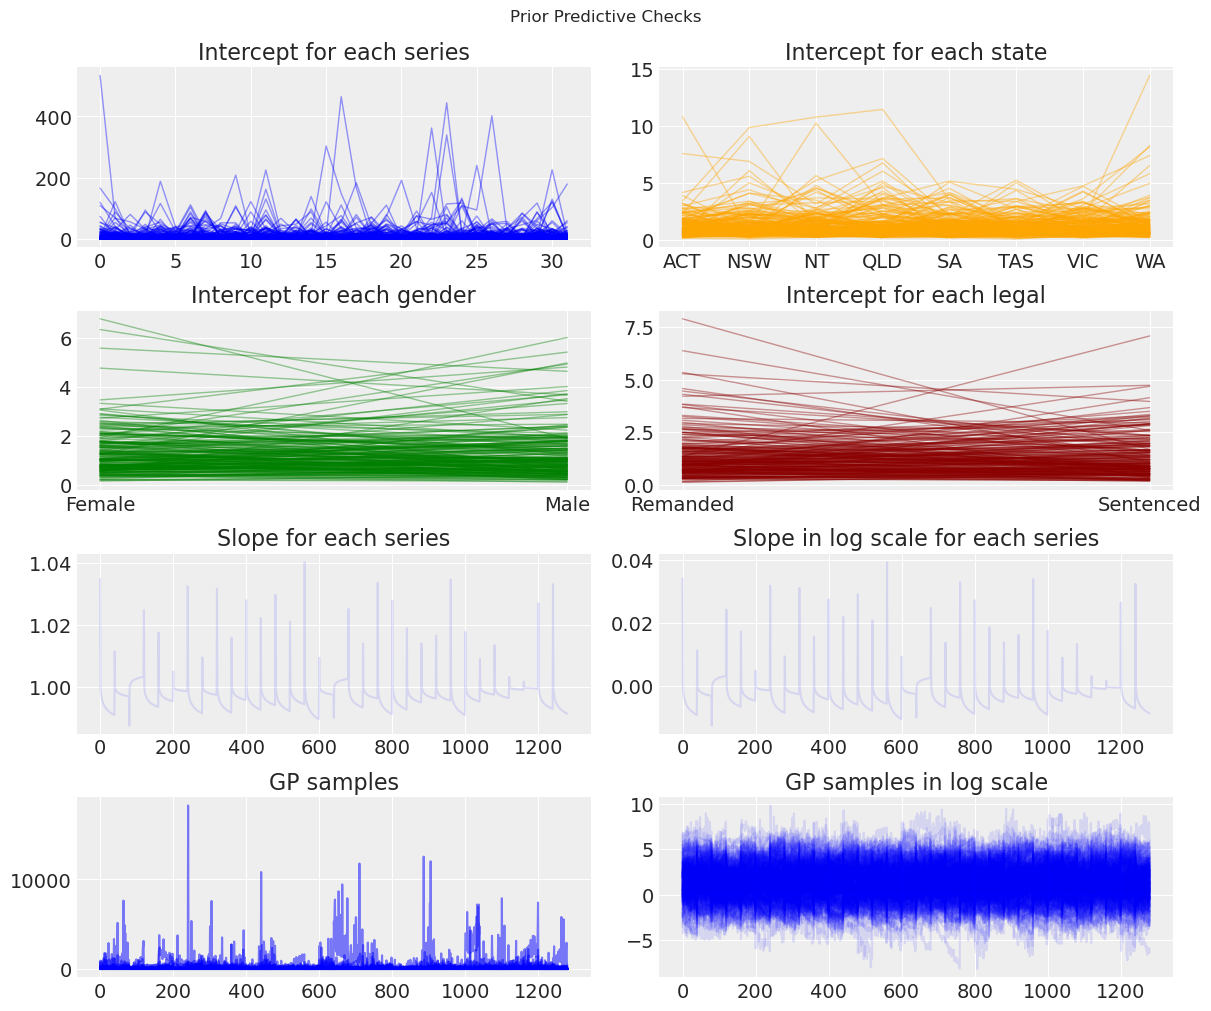

In [8]:
figure, ax = plt.subplots(4, 2, figsize=(12,10))
ax = ax.ravel()


figure.suptitle("Prior Predictive Checks")
ax[0].plot(np.exp(prior_checks['a0'].T), color='b', label='intercept', linewidth=1, alpha=0.4)
ax[0].set_title('Intercept for each series')

ax[1].plot(np.exp(prior_checks['a1'].T), color='orange', label= 'state', linewidth=1, alpha=0.4)
ax[1].set_xticks(np.arange(len(states_)))
ax[1].set_xticklabels(states_)
ax[1].set_title('Intercept for each state')

ax[2].plot(np.exp(prior_checks['a2'].T), color='green', label='gender', linewidth=1, alpha=0.4)
ax[2].set_xticks(np.arange(len(gender_)))
ax[2].set_xticklabels(gender_)
ax[2].set_title('Intercept for each gender')

ax[3].plot(np.exp(prior_checks['a3'].T), color='darkred',label='legal', linewidth=1, alpha=0.4);
ax[3].set_xticks(np.arange(len(legal_)))
ax[3].set_xticklabels(legal_)
ax[3].set_title('Intercept for each legal')

ax[4].plot(np.exp((np.log(np.tile(np.arange(n)+1e-6, (s, 1)).T) * np.tile(np.mean(prior_checks['b'], axis=0), (n,1))).T.ravel()), color='b', alpha=0.1)#, label=f'Series {states_[0]}, {gender_[0]} and {legal_[0]}')
ax[4].set_title('Slope for each series')
handles, labels = ax[4].get_legend_handles_labels()
ax[4].legend([handle for i,handle in enumerate(handles) if i%10==0],
      [label for i,label in enumerate(labels) if i%10==0], loc = 'best');

ax[5].plot((np.log(np.tile(np.arange(n)+1e-6, (s, 1)).T) * np.tile(np.mean(prior_checks['b'], axis=0), (n,1))).T.ravel(), color='b', alpha=0.1)#, label=f'Series {states_[0]}, {gender_[0]} and {legal_[0]}')
ax[5].set_title('Slope in log scale for each series')
handles, labels = ax[4].get_legend_handles_labels()
ax[5].legend([handle for i,handle in enumerate(handles) if i%10==0],
      [label for i,label in enumerate(labels) if i%10==0], loc = 'best');

# Plotting the GPs

ax[6].plot(np.exp(prior_checks['f'].T), color='b', alpha=0.5)
ax[6].set_title('GP samples');

ax[7].plot(prior_checks['f'].T, color='b', alpha=0.1)
ax[7].set_title('GP samples in log scale');

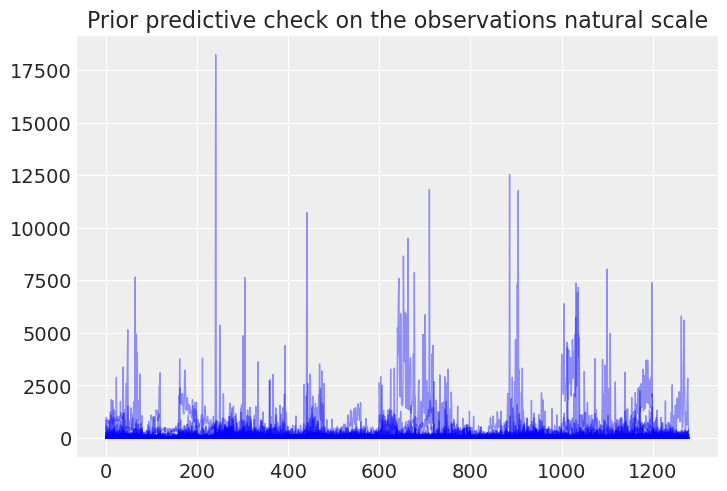

In [9]:
plt.plot(stats.poisson.rvs(np.exp(prior_checks['f'].T)), color='b', alpha=0.4, linewidth=1)
plt.title('Prior predictive check on the observations natural scale');

# Running the model

##### MAP

In [23]:
with model_h_cox_gp_cor:
    mp = pm.find_MAP()

In [25]:
model_fpath = 'gp.pkl'
with open(model_fpath, 'wb') as buff:
    pickle.dump({'model': model_h_cox_gp_cor, 'trace': mp, 'gp': gp}, buff)

In [9]:
with open('gp.pkl', 'rb') as buff:
    data = pickle.load(buff)  

model_h_cox_gp_cor, mp, gp = data['model'], data['trace'], data['gp']

In [10]:
model_h_cox_gp_cor

##### Complete MCMC

In [ ]:
with model_h_cox_gp_cor:
    trace_h_cox_gp_cor = pm.sample(draws=2000, 
                  tune=4000,
                  target_accept=0.90,
                  init='advi+adapt_diag',
                  chains=1,
                  cores=1)

##### Variational Inference

In [ ]:
with model_h_cox_gp_cor:   
    approx = pm.fit(method='fullrank_advi')
    trace = approx.sample(1000)

In [ ]:
plt.plot(approx.hist);

### Visual inspection of results

In [7]:
n_new = n+8
X_new = []
for s_ in range(s):    
    h = np.ones((n_new,1))*s_
    t = np.arange(n_new)[:,None]
    X_new.append(np.hstack((t, h)))

In [29]:
with model_h_cox_gp_cor:
    f_n0 = gp.conditional('f_n0', Xnew=X_new[0])
    
    y_pred_new0 = pm.Poisson("y_pred_new0", 
                            mu=pm.math.exp(f_n0), 
                            shape=X_new[0].shape[0])

In [30]:
with model_h_cox_gp_cor:
    pred_samples0 = pm.sample_posterior_predictive([mp], 
                                                  vars=[y_pred_new0], 
                                                  samples=100)

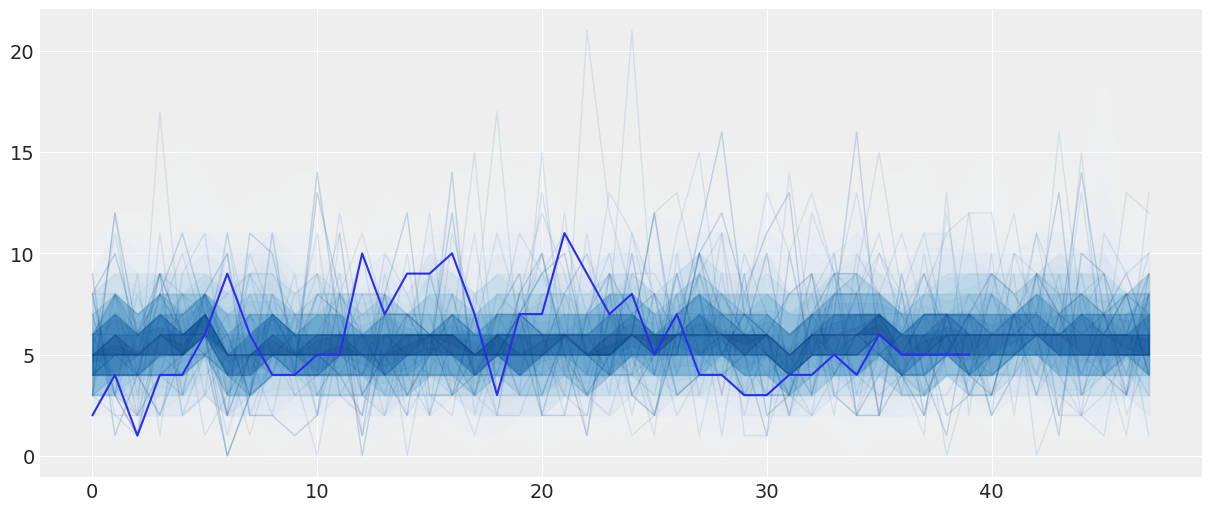

In [31]:
from pymc3.gp.util import plot_gp_dist
fig = plt.figure(figsize=(12,5)); ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist

plot_gp_dist(ax, pred_samples0['y_pred_new0'][:,:60], X_new[0][:60,0], palette="Blues", fill_alpha=0.1, samples_alpha=0.1);
plt.plot(np.arange(n),y[:,0]);

In [32]:
with model_h_cox_gp_cor:
    f_n1 = gp.conditional('f_n1', Xnew=X_new[1])
    y_pred_new1 = pm.Poisson("y_pred_new1", 
                            mu=pm.math.exp(f_n1), 
                            shape=X_new[0].shape[0])

In [33]:
with model_h_cox_gp_cor:
    f_n2 = gp.conditional('f_n2', Xnew=X_new[2])
    y_pred_new2 = pm.Poisson("y_pred_new2", 
                            mu=pm.math.exp(f_n2), 
                            shape=X_new[0].shape[0])

In [34]:
with model_h_cox_gp_cor:
    f_n3 = gp.conditional('f_n3', Xnew=X_new[3])
    y_pred_new3 = pm.Poisson("y_pred_new3", 
                            mu=pm.math.exp(f_n3), 
                            shape=X_new[0].shape[0])

In [35]:
with model_h_cox_gp_cor:
        pred_samples1 = pm.sample_posterior_predictive([mp], 
                                                  vars=[y_pred_new1], 
                                                  samples=100)

In [36]:
with model_h_cox_gp_cor:
        pred_samples2 = pm.sample_posterior_predictive([mp], 
                                                  vars=[y_pred_new2], 
                                                  samples=100)

In [37]:
with model_h_cox_gp_cor:
        pred_samples3 = pm.sample_posterior_predictive([mp], 
                                                  vars=[y_pred_new3], 
                                                  samples=100)

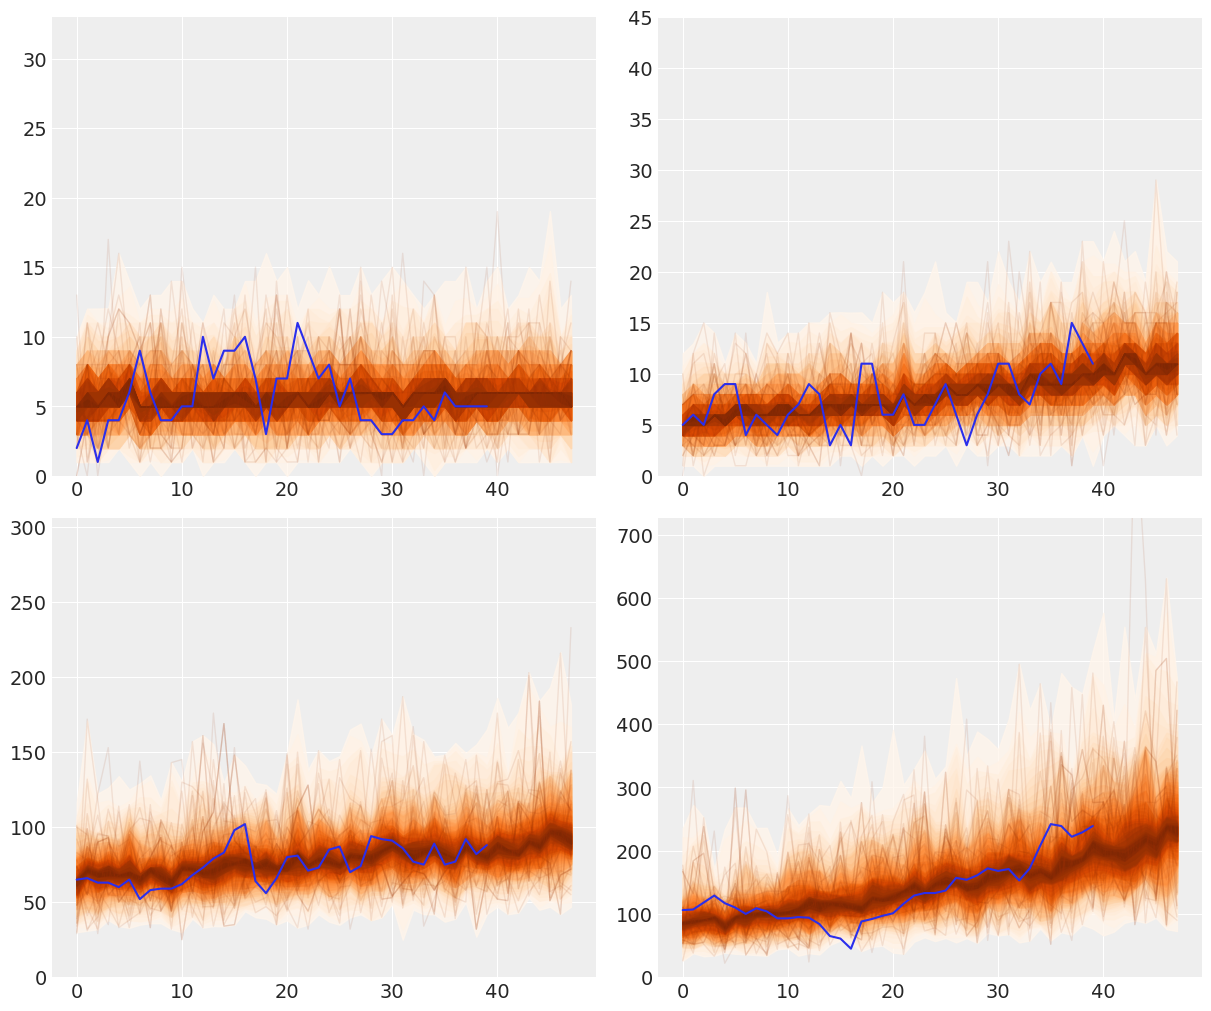

In [38]:
pred_samples_list = [
    pred_samples0,
    pred_samples1,
    pred_samples2,
    pred_samples3
]

fig, ax = plt.subplots(2, 2, figsize=(12,10))
ax = np.ravel(ax)
for s_ in range(4):
    #pm.gp.util.plot_gp_dist(ax[s_], list(pred_samples_list[s_].items())[0][1], np.arange(n*s_, n*s_+n_new), palette='Oranges')
    pm.gp.util.plot_gp_dist(ax[s_], list(pred_samples_list[s_].items())[0][1], np.arange(n_new), palette='Oranges')
    #ax[s_].plot(np.arange(n*s_, n*s_+n), y[:,s_])
    ax[s_].plot(np.arange(n), y[:,s_])
    ax[s_].set_ylim(0,max(y[:,s_])+max(y[:,s_])*2);

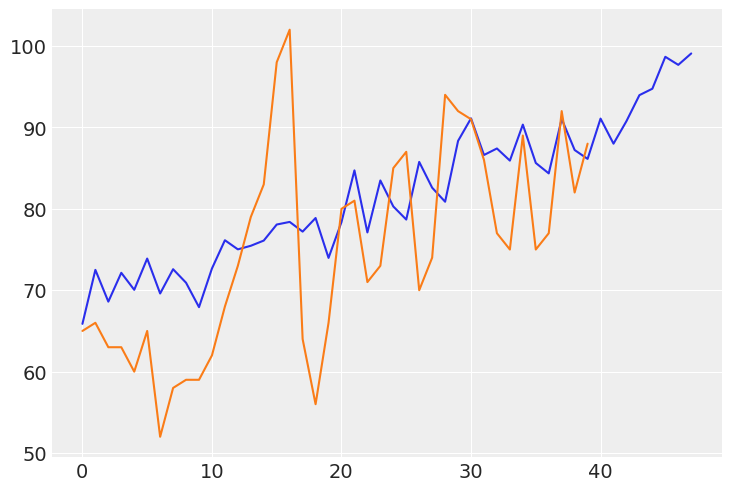

In [39]:
plt.plot(np.mean(pred_samples2['y_pred_new2'], axis=0))
plt.plot(y[:,2]);

# Results

https://arxiv.org/pdf/2006.02043.pdf

$$MASE = \frac{n-s}{h}\frac{\sum^{n+h}_{t=n+1}|y_t-f_t|}{\sum^n_{t=s+1}|y_t-y_{t-s}|}$$

where $y_t$ and $f_t$ are the observation and the forecast for period $t$,$n$ is the sample size (observations used for training the forecasting model), $s$ is the length of the seasonal period, and $h$ is the forecasting horizon. Lower values indicate better forecasts.

Note that measure is scale-independent, meaning that averaging across series is possible.

In [10]:
n_new = n+8
X_new = []
for s_ in range(s):    
    h = np.ones((n_new-n,1))*s_
    t = np.arange(n, n_new)[:,None]
    X_new.append(np.hstack((t, h)))

In [12]:
def mase(n,s,h,y,f):
    return ((n-s)/h
            * (np.sum(y[n:n+h] - f[n:n+h]) 
               / np.sum(y[s,n] - y[:n])))

In [11]:
# Generate forecasts for all series
y_pred_new=[]
with model_h_cox_gp_cor:
    for i in range(s):
        print('conditioning series ' + str(i) + "...")
        f_pred = gp.conditional('f_pred%d' % i, Xnew=X_new[i])
        y_pred_new.append(pm.Poisson("y_pred%d" % i, 
                            mu=pm.math.exp(f_pred), 
                            shape=X_new[0].shape[0]))

conditioning series 0...
conditioning series 1...
conditioning series 2...
conditioning series 3...
conditioning series 4...
conditioning series 5...
conditioning series 6...
conditioning series 7...
conditioning series 8...
conditioning series 9...
conditioning series 10...
conditioning series 11...
conditioning series 12...
conditioning series 13...
conditioning series 14...
conditioning series 15...
conditioning series 16...
conditioning series 17...
conditioning series 18...
conditioning series 19...
conditioning series 20...
conditioning series 21...
conditioning series 22...
conditioning series 23...
conditioning series 24...
conditioning series 25...
conditioning series 26...
conditioning series 27...
conditioning series 28...
conditioning series 29...
conditioning series 30...
conditioning series 31...


In [ ]:
model_fpath = 'gp_cond.pkl'
with open(model_fpath, 'wb') as buff:
    pickle.dump({'model': model_h_cox_gp_cor, 'trace': mp, 'gp': gp}, buff)

In [12]:
pred_samples=[]
with model_h_cox_gp_cor:
    for i in range(s):
        print('generating samples for series ' + str(i) + '...')
        pred_samples.append(pm.sample_posterior_predictive([mp], 
                                                  vars=[y_pred_new[i]], 
                                                  samples=100))

generating samples for series 0...


generating samples for series 1...


generating samples for series 2...


generating samples for series 3...


generating samples for series 4...


generating samples for series 5...


generating samples for series 6...


generating samples for series 7...


generating samples for series 8...


generating samples for series 9...


generating samples for series 10...


generating samples for series 11...


generating samples for series 12...


generating samples for series 13...


generating samples for series 14...


generating samples for series 15...


generating samples for series 16...


generating samples for series 17...


generating samples for series 18...


generating samples for series 19...


generating samples for series 20...


generating samples for series 21...


generating samples for series 22...


generating samples for series 23...


generating samples for series 24...


generating samples for series 25...


generating samples for series 26...


generating samples for series 27...


generating samples for series 28...


generating samples for series 29...


generating samples for series 30...


generating samples for series 31...


In [20]:
y_h

state           ACT                                   NSW                     \
gender       Female               Male             Female               Male   
legal      Remanded Sentenced Remanded Sentenced Remanded Sentenced Remanded   
t                                                                              
2015-03-01        7        14       92       218      298       493     3124   
2015-06-01        8        12      113       219      303       543     3278   
2015-09-01        6        11      109       240      305       575     3431   
2015-12-01       11         8      116       264      305       570     3490   
2016-03-01       13        13      117       270      349       552     3749   
2016-06-01       11        16      127       254      414       526     3850   
2016-09-01       11        17      133       267      425       542     3829   
2016-12-01       12        14      143       268      426       587     3873   

state                      NT            ...      TAS                VIC  \
gender                 Female            ...     Male             Female   
legal      Sentenced Remanded Sentenced  ... Remanded Sentenced Remanded   
t                                        ...                               
2015-03-01      7190       53        86  ...      103       337      132   
2015-06-01      7493       50        93  ...      113       371      134   
2015-09-01      7595       43        99  ...      129       347      135   
2015-12-01      7815       51       114  ...      133       350      146   
2016-03-01      7742       50        92  ...      138       349      158   
2016-06-01      7853       40        88  ...      130       374      158   
2016-09-01      7927       43        81  ...      142       381      170   
2016-12-01      7919       38        77  ...      141       401      175   

state                                         WA                               
gender                   Male             Female               Male            
legal      Sentenced Remanded Sentenced Remanded Sentenced Remanded Sentenced  
t                                                                              
2015-03-01       318     1392      4631      156       376     1073      3833  
2015-06-01       296     1357      4505      147       380     1135      3843  
2015-09-01       287     1281      4386      141       373     1191      3864  
2015-12-01       276     1438      4442      160       357     1314      3894  
2016-03-01       278     1588      4363      171       367     1425      3876  
2016-06-01       278     1716      4305      206       401     1566      3969  
2016-09-01       263     1801      4364      226       396     1623      4076  
2016-12-01       268     1915      4418      208       404     1608      4088  

[8 rows x 32 columns]

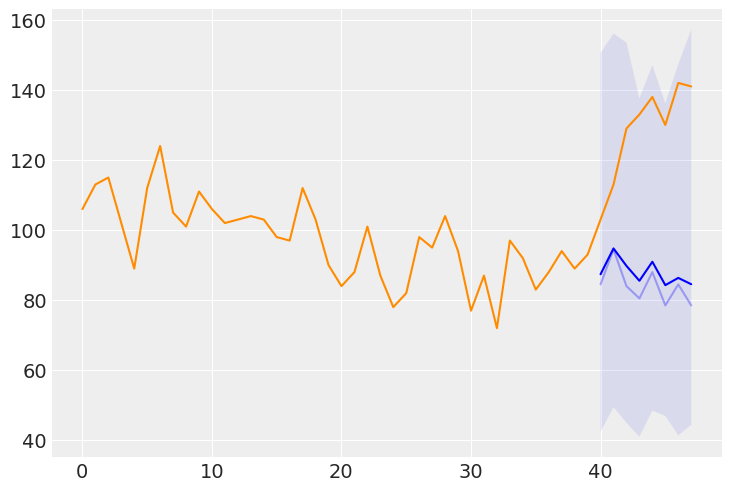

In [63]:
series = 22

ci = np.percentile(pred_samples[series]['y_pred%d'%series], axis=0, q=[2.5, 50, 97.5])

plt.plot(np.arange(40, 48),ci[1] , color='b', alpha=0.3)
plt.fill_between(np.arange(40, 48),ci[0], ci[2], alpha=0.1)
plt.plot(np.arange(40, 48),np.mean(pred_samples[series]['y_pred%d'%series], axis=0), color='b')
plt.plot(y_all[:,series], color='darkorange');